In [7]:
from __future__ import print_function
import argparse
import torch
from PIL import Image
from torchvision.transforms import ToTensor

import numpy as np

In [86]:
input_image = "super_resolution/dataset/BSDS300/images/test/119082.jpg" #"../../Downloads/adam.jpeg" # 
opt_model = "super_resolution/models/BayesianNet/epoch_1_upscale_factor_3_device_cpu.pth"
output_filename = "out.png"

#parser.add_argument('--cuda', action='store_true', help='use cuda')

In [89]:
def load_model(model_name, epoch, factor, device):
    #print(model.state_dict()['conv1.W_mu'][0])
    
    model = torch.load(f'super_resolution/models/{model_name}/epoch_{epoch}_upscale_factor_{factor}_device_{device}.pth')
    print(model)
    return model

In [60]:
def set_var_scale(scale):
    model.conv1.uncertainty_scale = scale
    model.conv2.uncertainty_scale = scale
    model.conv3.uncertainty_scale = scale
    model.conv4.uncertainty_scale = scale

tensor([[[0.5294, 0.4745, 0.4824,  ..., 0.7020, 0.7608, 0.7765],
         [0.4314, 0.3961, 0.5333,  ..., 0.6588, 0.6706, 0.6902],
         [0.4235, 0.4863, 0.4941,  ..., 0.6392, 0.6627, 0.6824],
         ...,
         [0.3098, 0.5412, 0.7137,  ..., 0.5686, 0.6627, 0.5725],
         [0.2196, 0.2863, 0.4078,  ..., 0.4314, 0.4627, 0.6353],
         [0.1882, 0.2039, 0.2392,  ..., 0.3020, 0.2902, 0.3922]]])


In [119]:
#if cuda:
    #model = model.cuda()
    #input = input.cuda()
    
def convert_to_image(y, cb, cr, fname):
    out_img_y = y * 255.0
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

    out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
    out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')
    
    print('saved to ', fname)
    out_img.save(fname)
    plt.imshow(out_img)
    plt.show()

In [123]:
import matplotlib.pyplot as plt

def upscale_image(model, input_image, variance_scale=1):
    img = Image.open(input_image).convert('YCbCr')
    y, cb, cr = img.split()

    img_to_tensor = ToTensor()
    input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0])
    
    
    set_var_scale(variance_scale)
    out, kl = model(input)
    out = out.cpu()
    out = out[0].detach().numpy()
    
    print("Image with variance scale of", variance_scale)
    fname = f"variance_{variance_scale}_{output_filename}"
    convert_to_image(out, cb, cr, fname)

BayesianNet(
  (conv1): BBBConv2d()
  (conv2): BBBConv2d()
  (conv3): BBBConv2d()
  (conv4): BBBConv2d()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)
Image with variance scale of 0
saved to  variance_0_out.png


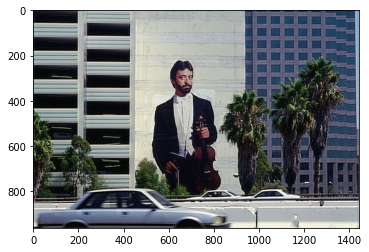

Image with variance scale of 1
saved to  variance_1_out.png


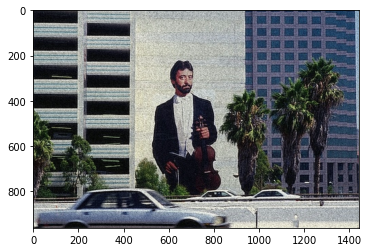

Image with variance scale of 2
saved to  variance_2_out.png


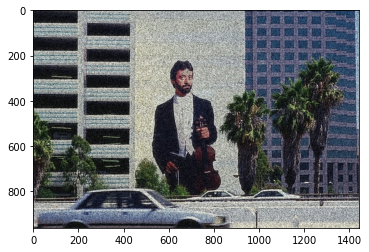

Image with variance scale of 5
saved to  variance_5_out.png


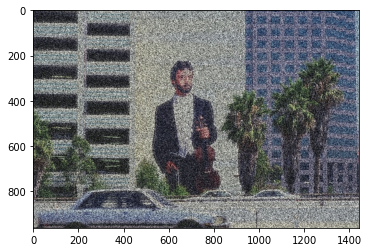

Image with variance scale of 100
saved to  variance_100_out.png


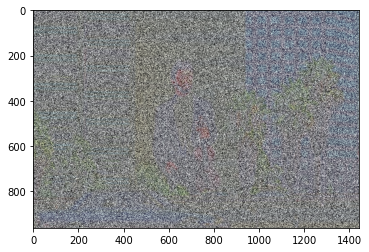

In [125]:
model = load_model("BayesianNet", epoch=10, factor=3, device="cpu")

for variance_scale in [0, 1, 2, 5, 100]:
    upscale_image(model, input_image, variance_scale)

In [113]:
from super_resolution.data import get_test_set

def test_comparison(model, upscale_factor):
    test_set = get_test_set(upscale_factor)
    
    img = Image.open("super_resolution/dataset/BSDS300/images/test/119082.jpg").convert('YCbCr')
    y, cb, cr = img.split()

    for i, test in enumerate(test_set): #Ugly code, but finds this specific cropped and original image
        if i == 74:
            break

    print("Original image:")     
    convert_to_image(test[1], cb, cr, "original_image.png")
    
    
    print("Cropped image:")     
    convert_to_image(test[0], cb, cr, "cropped_image.png")
    

    print("Upscaled cropped image:")
    t = torch.unsqueeze(test[0], dim=0)
    
    if 'Bayesian' in model.__class__.__name__:
        out, kl = model(t)
    else:
        out = model(t)
        
    out = out[0].detach().numpy()
    
    convert_to_image(out, cb, cr, "upscaled_cropped_image.png")

In [114]:
model

BayesianNet(
  (conv1): BBBConv2d()
  (conv2): BBBConv2d()
  (conv3): BBBConv2d()
  (conv4): BBBConv2d()
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

Original image:


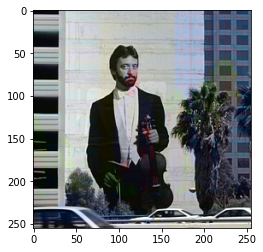

Cropped image:


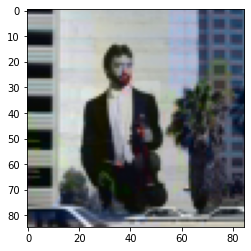

Upscaled cropped image:


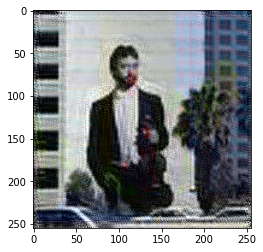

In [115]:
test_comparison(model, 3)

Net(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)
Original image:


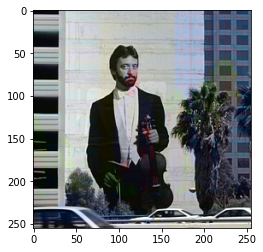

Cropped image:


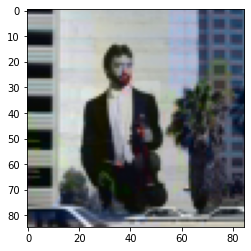

Upscaled cropped image:


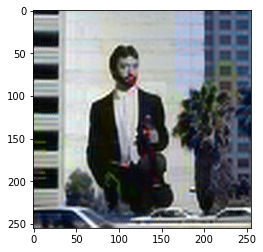

In [116]:
model = load_model("Net", 30, 3, "cpu")
test_comparison(model, 3)